In [1]:
import os
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

In [4]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


## Pruning

In [21]:
def global_unstructure_prune(model, pruning_amount=0.2):

    parameters_to_prune = []
    for name, module in model.named_modules():
        # print(name)
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount
    )

    # print(
    # "Sparsity in fc2.weight: {:.2f}%".format(
    #     100. * float(torch.sum(model.fc.weight == 0))
    #     / float(model.fc.weight.nelement())
    # )
    # )

    # Make the pruning permanent
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

In [8]:
from tqdm import tqdm

In [28]:
pcts = [0, 0.1, 0.2, 0.85, 0.9, 0.95, 0.99, 0.999]
ret_accs = []
test_accs = []

ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

ret_accs.append(100.0 * accuracy(ft_model, retain_loader))
test_accs.append(100.0 * accuracy(ft_model, test_loader))


for pct in tqdm(pcts):
    if pct==0:
        continue
    ft_model = resnet18(weights=None, num_classes=10)
    ft_model.load_state_dict(weights_pretrained)
    ft_model.to(DEVICE)

    # Apply pruning
    global_unstructure_prune(ft_model, pct)

    ret_accs.append(100.0 * accuracy(ft_model, retain_loader))
    test_accs.append(100.0 * accuracy(ft_model, test_loader))

100%|██████████| 5/5 [01:24<00:00, 16.92s/it]


Text(0.5, 0, 'Sparsity')

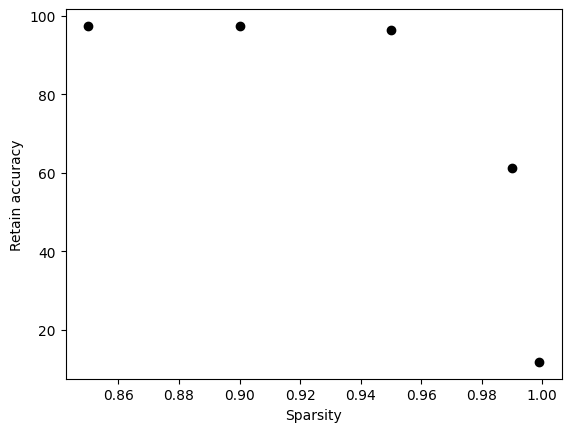

In [29]:
plt.plot(pcts, ret_accs, 'ko')
plt.ylabel('Retain accuracy')
plt.xlabel('Sparsity')

Text(0.5, 0, 'Sparsity')

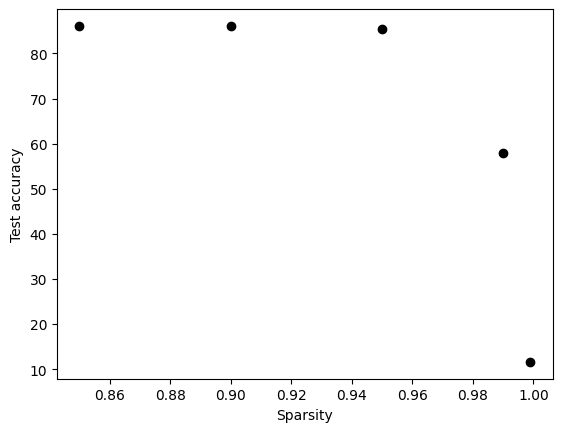

In [30]:
plt.plot(pcts, test_accs, 'ko')
plt.ylabel('Test accuracy')
plt.xlabel('Sparsity')